<a href="https://colab.research.google.com/github/Andrei-WongE/ML_sandbox/blob/origin/Class_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REPRESENTATION LEARNING - AUTOENCODERS

In [1]:
#Need to first set up Colab’s runtime environment to use GPUs or TPUs instead of CPUs.
# select “Change runtime type” under “Runtime” from Colab’s menu bar.

import tensorflow as tf

device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))


Found GPU at: /device:GPU:0


In [4]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
print(tf.__version__)

from __future__ import print_function
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam

2.15.0


In [6]:
# Checking
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


import the mnist data and shape it:

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
print(x_train.shape)
print(x_test.shape)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)
(60000, 784)
(10000, 784)


Before we used to add layers using
the sequential API as follows:

```
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
```



## A Simple Autoencoder

In [ ]:
# With the functional API we do this:
layer_1 = Dense(16, activation='relu')(input)
layer_2 = Dense(8, activation='relu')(layer_1)

The output of Dense method is a
callable layer, using the functional API we provide it with the input and store the output. The output
of a layer becomes the input of the next layer. With the sequential API the add method implicitly
handled this for us.

In [11]:
# Function to implement our autoencoders
def auto_encoder_model(p_hidden_size=128, p_code_size=32, sparse=False, regval=10e-6):
  input_size = 784
  hidden_size = p_hidden_size
  code_size = p_code_size
  input_img = Input(shape=(input_size,))
  hidden_1 = Dense(hidden_size, activation='relu')(input_img)

  if sparse:
    code = Dense(code_size, activation='relu',
  activity_regularizer = l1(regval))(hidden_1)
  else:
    code = Dense(code_size, activation='relu')(hidden_1)
  hidden_2 = Dense(hidden_size, activation='relu')(code)
  output_img = Dense(input_size, activation='sigmoid')(hidden_2)

  autoencoder = Model(input_img, output_img)
  encoded = Model(input_img, code)

  return autoencoder, encoded

In [12]:
# generate an autoencoder model
autoencoder, _ = auto_encoder_model()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 8s 3ms/step - loss: 0.1398
Epoch 2/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1009
Epoch 3/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0953


visualize how well our autoencoder reconstructs its input

313/313 [==============================] - 0s 2ms/step


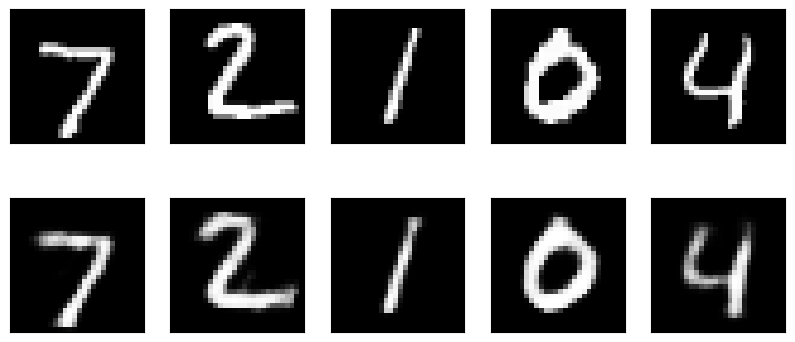

In [17]:
def plot_image_comparison(base_images, comparison_images, p_n = 5, dims=(28,28) ):
  decoded_imgs = autoencoder.predict(x_test)
  # number of example digits to show
  n = p_n
  plt.figure(figsize=(10, 4.5))
  for i in range(n):
    # plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(base_images[i].reshape(*dims))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    if i == n/2:
      ax.set_title('Original Images')
    # plot reconstruction
    ax = plt.subplot(2, n, i + 1+ n)
    plt.imshow(comparison_images[i].reshape(*dims))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    if i == n/2:
      ax.set_title('Reconstructed Images')

plt.show()

plot_image_comparison(x_test, autoencoder.predict(x_test))

##Denoising Autoencoder

313/313 [==============================] - 0s 2ms/step


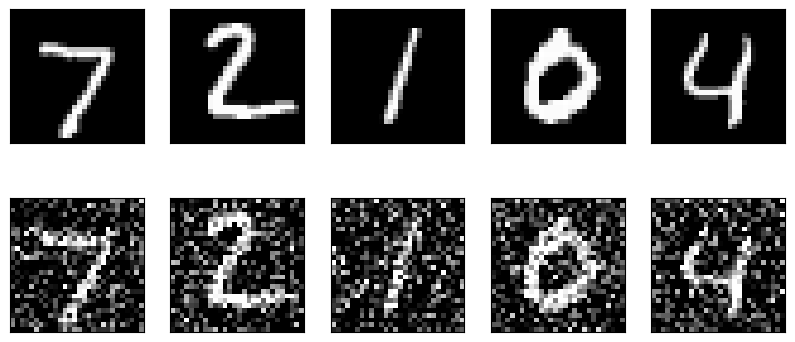

In [18]:
#Creating noisy input

noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)
plot_image_comparison(x_test, x_test_noisy)

If we let our previously trained autoencoder try to reproduce the images when given the noisy input,
we can see that it doesn’t do very well.

313/313 [==============================] - 1s 2ms/step


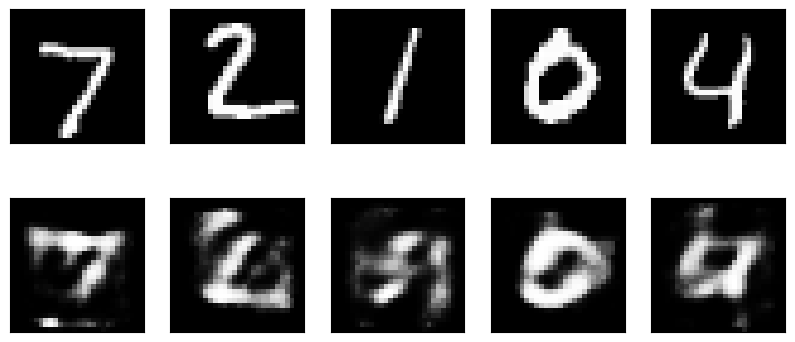

In [19]:
plot_image_comparison(x_test, autoencoder.predict(x_test_noisy))

To get a better fit we need to make one small difference between the implementation of denoising
autoencoder and the regular one. The architecture doesn’t change at all, only the fit function.

In [21]:
#Denoising autoencoder is trained as:
autoencoder.fit(x_train_noisy, x_train)

1875/1875 [==============================] - 6s 3ms/step - loss: 0.1170


implement the denoising autoencoder and see its results.

In [22]:
autoencoder.fit(x_train_noisy, x_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1119
Epoch 2/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1101
Epoch 3/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1089


visualize whether we are able to recover the noise-free images

313/313 [==============================] - 1s 2ms/step


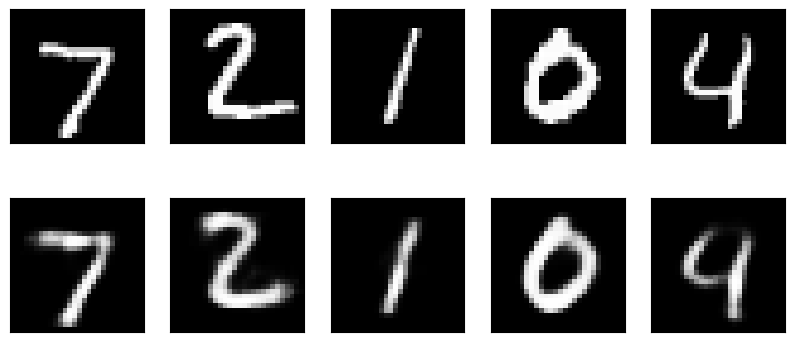

In [23]:
plot_image_comparison(x_test, autoencoder.predict(x_test_noisy))

##Sparse Autoencoders

We can regularize the
autoencoder by using a sparsity constraint such that only a fraction of the nodes would have
nonzero values, called active nodes. We add a penalty term to the loss function such that only a fraction of the nodes
become active. <br>
This forces the autoencoder to represent each input as a combination of small
number of nodes, and demands it to discover interesting structure in the data.

creates a regular
autoencoder and a regularized one so we can compare their outputs.

In [29]:
#Sparse = False used this to set up the central code layer
autoencoder_standard, encoded_standard = auto_encoder_model(sparse=False)
autoencoder_standard.compile(optimizer='adam',loss='binary_crossentropy')
history_standard=autoencoder_standard.fit(x_train,x_train,epochs=3)

#When specifying Sparse = True, we add another parameter called activity_regularizer by
#specifying the regularization strength. This is typically a value in the range [0.001, 0.000001].
autoencoder_regularized, encoded_regularized = auto_encoder_model(sparse=True,regval=10e-6)
autoencoder_regularized.compile(optimizer='adam',loss='binary_crossentropy')
history_regularized=autoencoder_regularized.fit(x_train,x_train,epochs=3)

Epoch 1/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1367
Epoch 2/3
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0974
Epoch 3/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0924
Epoch 1/3
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1360
Epoch 2/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0986
Epoch 3/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0933


compare the reconstructed images with the original images for the two models

Standard AutoEncoder Comparison
313/313 [==============================] - 1s 2ms/step
Regularized AutoEncoder Comparison
313/313 [==============================] - 0s 2ms/step


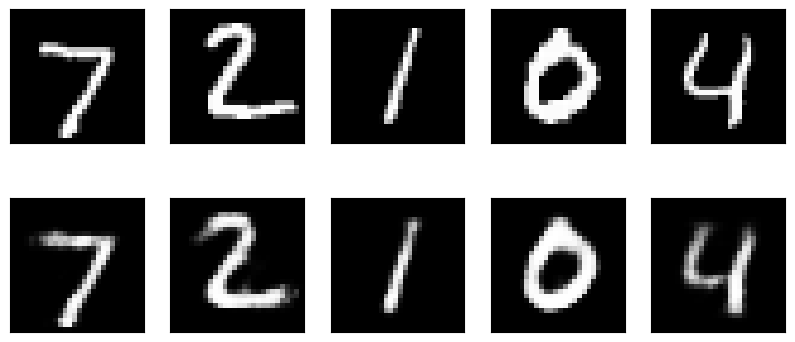

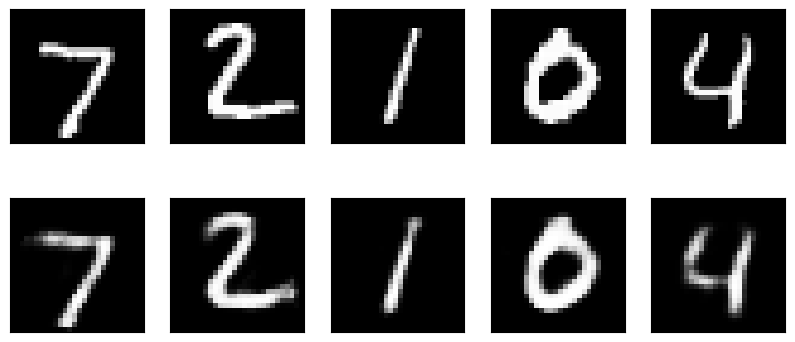

In [30]:
print("Standard AutoEncoder Comparison")
plot_image_comparison(x_test, autoencoder_standard.predict(x_test))
print("Regularized AutoEncoder Comparison")
plot_image_comparison(x_test, autoencoder_regularized.predict(x_test))

Comparing the loss histories of the two models

In [31]:
print('Standard Loss History')
print(history_standard.history.items())
print('Loss History with Regularization')
print(history_regularized.history.items())

Standard Loss History
dict_items([('loss', [0.1366778016090393, 0.09736019372940063, 0.09244412928819656])])
Loss History with Regularization
dict_items([('loss', [0.13601544499397278, 0.09857915341854095, 0.09327603131532669])])


intermediate representations of the images from the code layer and we want to see how the values
vary between the two images by using the histogram of code values for the images in the test set.

313/313 [==============================] - 0s 1ms/step
Standard model mean values 7.445 with stdev 4.183
Regularized model mean values 4.880 with stdev 2.855


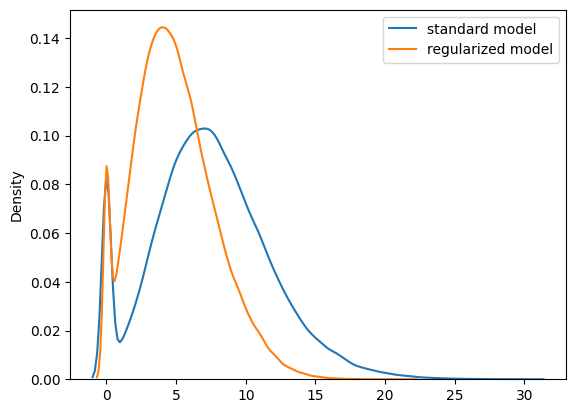

In [32]:
standard_scores = encoded_standard.predict(x_test).ravel()
regularized_scores = encoded_regularized.predict(x_test).ravel()
print('Standard model mean values %0.3f with stdev %0.3f' % (standard_scores.mean(), standard_scores.std()))
print('Regularized model mean values %0.3f with stdev %0.3f' % (regularized_scores.mean(), regularized_scores.std()))

sns.distplot(standard_scores, hist=False, label='standard model')
sns.distplot(regularized_scores, hist=False, label='regularized model')

plt.legend()

In [33]:
#Number of values up to each range
ss=[]
rs=[]

for i in range(10):
  ss.append(sum(abs(standard_scores)<=i))
  rs.append(sum(abs(regularized_scores)<=i))

print("up to a value of %2d, there are %6d instances in original model and %6d in the regularized model" % (i,ss[i],rs[i]))

up to a value of  9, there are 214667 instances in original model and 291900 in the regularized model
